In [1]:
!pip install transformers torch pandas matplotlib spacy
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
from transformers import pipeline

In [3]:
generator = pipeline("text2text-generation", model="google/flan-t5-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("news_examples_30.csv", encoding="ISO-8859-1")

Saving news_examples_30.csv to news_examples_30 (1).csv


In [25]:
def make_prompt(text, tone="breaking", strategy="zero"):
    if strategy == "zero":
        return f"Rewrite this news as a {tone} tweet (280 chars max):\n{text}"
    elif strategy == "instruct":
        return f"Summarize this news in a {tone} tone for Twitter. Use emojis if helpful:\n{text}"
    elif strategy == "fewshot":
        examples = (
            "News: Scientists discover a new Earth-like planet.\n"
            "Tweet (tone: breaking): BREAKING: Earth 2.0 discovered? NASA might’ve just found a habitable twin! \n\n"
            "News: FDA approves new Alzheimer’s drug.\n"
            "Tweet (tone: health): Huge step forward — new Alzheimer’s drug could slow memory loss. \n\n"
        )
        return examples + f"News: {text}\nTweet (tone: {tone}):"

In [16]:
def generate_tweet(text, tone="breaking", strategy="zero"):
    prompt = make_prompt(text, tone, strategy)
    output = generator(prompt, max_new_tokens=100, do_sample=True, temperature=0.9)
    return output[0]["generated_text"].split("Tweet")[-1].strip()

In [15]:
missing_combos = [
    ("funny", "fewshot"),
    ("policy", "zero"),
    ("policy", "instruct"),
    ("policy", "fewshot"),
]

for tone, strategy in missing_combos:
    col = f"{tone}_{strategy}"
    if col not in df.columns:
        print(f"Generating: {col}")
        df[col] = df["text"].apply(lambda x: generate_tweet(x, tone=tone, strategy=strategy))

Generating: funny_fewshot
Generating: policy_zero
Generating: policy_instruct
Generating: policy_fewshot


In [26]:
for tone, strategy in missing_combos:
    col = f"{tone}_{strategy}"
    if col in df.columns:
        print(f"\nPreview: {col}")
        print(df[[col]].dropna().head(3))


Preview: funny_fewshot
                                       funny_fewshot
0  BREAKING: Scientists discovered a new planet t...
1  Paris announced a ban on gas-powered cars by 2...
2  NASA launched a telescope to find Earth-like p...

Preview: policy_zero
                                         policy_zero
0  Scientists have discovered a new planet that m...
1  Paris announced a ban on gas-powered cars by 2...
2  NASA launched a telescope to find Earth-like p...

Preview: policy_instruct
                                     policy_instruct
0  Scientists have discovered a new planet that m...
1  Paris announced a ban on gas-powered cars by 2...
2  NASA launched a telescope to find Earth-like p...

Preview: policy_fewshot
                                      policy_fewshot
0  BREAKING: Scientists discovered a new planet t...
1  Paris has announced a ban on gas-powered cars ...
2  NASA launched a telescope to find Earth-like p...


In [19]:
def fast_score(df, col):
    length = df[col].str.len().clip(upper=280) / 280
    hashtags = df[col].str.count("#") / 2
    capital_words = df[col].str.findall(r"\b[A-Z]{4,}\b").str.len()
    capital_score = (capital_words > 0).astype(int)
    return (length + hashtags + capital_score).round(2)

tones = ["breaking", "funny", "policy"]
strategies = ["zero", "instruct", "fewshot"]

for tone in tones:
    for strategy in strategies:
        col = f"{tone}_{strategy}"
        if col in df.columns:
            df[f"{col}_style"] = fast_score(df, col)

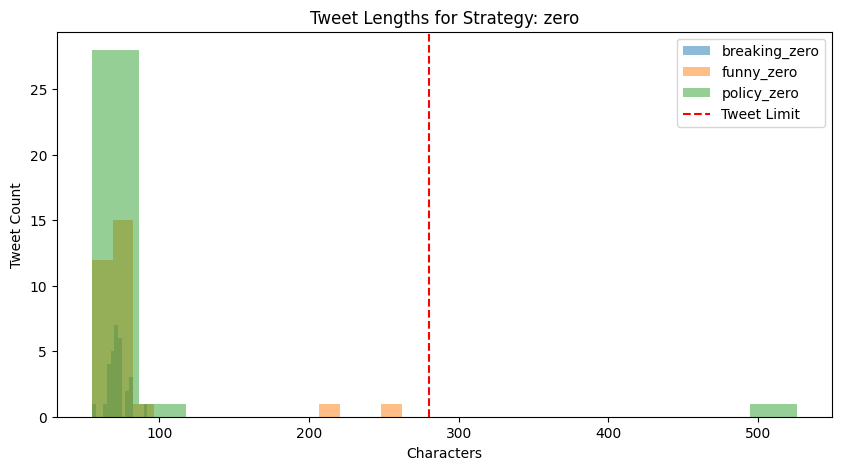

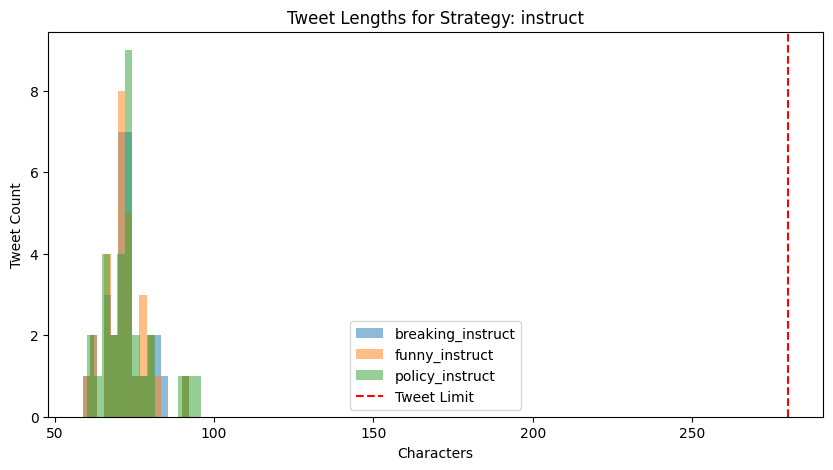

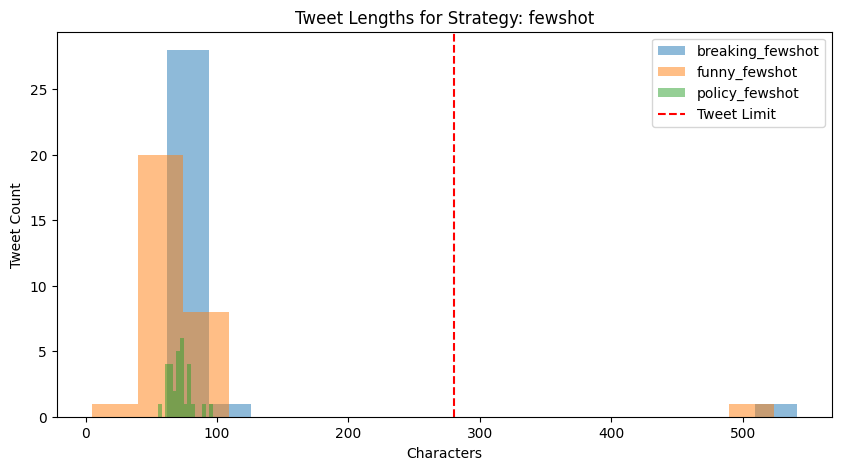

In [20]:
for strategy in strategies:
    plt.figure(figsize=(10, 5))
    for tone in tones:
        col = f"{tone}_{strategy}"
        if col in df.columns:
            plt.hist(df[col].str.len(), bins=15, alpha=0.5, label=col)
    plt.axvline(280, color='red', linestyle='--', label="Tweet Limit")
    plt.title(f"Tweet Lengths for Strategy: {strategy}")
    plt.xlabel("Characters")
    plt.ylabel("Tweet Count")
    plt.legend()
    plt.show()

In [22]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [23]:
def entity_overlap(news, tweet):
    doc1 = nlp(news)
    doc2 = nlp(tweet)
    ents1 = set(e.text.lower() for e in doc1.ents)
    ents2 = set(e.text.lower() for e in doc2.ents)
    return len(ents1 & ents2) / max(1, len(ents1))

for tone in tones:
    for strategy in strategies:
        col = f"{tone}_{strategy}"
        if col in df.columns:
            df[f"{col}_entity"] = df.apply(lambda row: entity_overlap(row["text"], row[col]), axis=1)

In [30]:
summary = []

for tone in ["breaking", "funny", "policy"]:
    for strategy in ["zero", "instruct", "fewshot"]:
        col = f"{tone}_{strategy}"
        style_col = f"{col}_style"
        entity_col = f"{col}_entity"

        if style_col in df.columns and entity_col in df.columns:
            avg_style = df[style_col].mean()
            avg_entity = df[entity_col].mean()
            avg_length = df[col].str.len().mean()
            summary.append({
                "Tone": tone,
                "Strategy": strategy,
                "Avg Style Score": round(avg_style, 2),
                "Avg Entity Score": round(avg_entity, 2),
                "Avg Tweet Length": round(avg_length, 1)
            })

summary_df = pd.DataFrame(summary)
summary_df.to_csv("summary_scores.csv", index=False)


In [31]:
from google.colab import files
files.download("summary_scores.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
df.to_csv("final_llm_outputs.csv", index=False)
from google.colab import files
files.download("final_llm_outputs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
with open("requirements.txt", "w") as f:
    f.write("transformers>=4.30.0\npandas\nmatplotlib\nspacy")

In [33]:
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>